<a href="https://colab.research.google.com/github/AmauryFaure/project_article_1/blob/master/Project_A1_CamemBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Inspire :

Notebook réalisé par Amaury Faure dans le cadre d'un projet d'intégration G3 réalisé avec INSPIRE, un des programmes de l'association Article 1. 

Ce notebook contient des explorations d'algorithmes simples de classification de messages. On utilise dans ce notebook CamemBERT pour la classification.


## Initialisation:

In [1]:
#Connecting to Drive to get files.
#Other options is to upload files to local machine (if using google colab)
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
#Importing pandas and numpy
import pandas as pd
import numpy as np
from joblib import dump, load

## Création du dataset d'entaînement :

In [3]:
#Get tweets
df_to_moderate=pd.read_csv("/content/drive/MyDrive/article_1_data/selected_tweets.csv")
#Drop unused data
df_to_moderate=df_to_moderate.drop(["Id","source","Looked up word"],axis=1)
#Change column name
df_to_moderate["content"]=df_to_moderate["tweet (without @)"]
df_to_moderate=df_to_moderate.drop(["tweet (without @)"], axis=1)
#Drop empty lines
df_to_moderate=df_to_moderate.dropna()

In [4]:
#Get regular data
df_article1_messages=pd.read_excel("/content/drive/MyDrive/article_1_data/AmauryModerationAllMessagesInspireFrom3Aout2020.xlsx", sheet_name="ContenuNormal")
#Drop unused data
df_article1_messages=df_article1_messages.drop(["_id","sender","recipients.0","threadId","timestamp","EchantillonNormal"], axis=1)
#Assign label
df_article1_messages["Harmful"]=0

In [5]:
#Create training dataset. Balanced 50% for each class !
df_to_moderate=pd.concat([df_article1_messages[:200],df_to_moderate],ignore_index=True)

## Création du dataset de test :

Il y a un problème car nous n'avons pas de dataset d'exemples de message "a modérer" d'INSPIRE.

On va donc tenter une analyse par 2 approches :
- Test sur le dataset de tweets MLMA (sans les tweets d'entraînement)
- Evaluation du % de messages d'Article 1 qui sont identifié comme messages à modérer actuellement et qui sont identifié comme à modéré par l'algorithme. 


### Création du set de test MLMA :

In [6]:
test=pd.read_csv("/content/drive/MyDrive/article_1_data/fr_dataset_test.csv")
#Dropping Unused columns
test=test.drop(test.columns[[7,8,9]],axis=1)
test=test.drop(columns=["HITId","directness","annotator_sentiment","target","group"])
#Changing sentiment to 0 (for normal) and 1 (for else) 
test["sentiment"]=[0 if test["sentiment"][x]=="normal" else 1 for x in range(test.shape[0])]

### Création du set de test INSPIRE :


In [7]:
df_a1_to_moderate=pd.read_excel("/content/drive/MyDrive/article_1_data/AmauryModerationAllMessagesInspireFrom3Aout2020.xlsx", sheet_name="ContenuToModerate")
df_a1_to_moderate=df_a1_to_moderate.drop(columns=["_id","sender","recipients.0","threadId","timestamp","EchantillonToModerate"])
# df_a1_to_moderate.columns=df_a1_to_moderate.columns.str.replace("\n"," ")
df_a1_to_moderate.head()

,content
0,"Non, la physique-chimie de lycée n’a pas grand..."
1,Merci infiniment d'avoir pris autant de temps ...
2,Bonjour ! Alors non la SVT et la biologie ce n...
3,salut\nJ'aimerais savoir ce qu'est exactement ...
4,je sais pas si j'ai répondu à toutes tes quest...


### Implémentation de CamemBERT

Cette implémentation va être réalisé avec Huggingface Transformers et PyTorch.
In this attempt we are going to use transformers and PyTorch, using the latter for training.

In [8]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 1.9MB 8.4MB/s 
     |████████████████████████████████| 890kB 50.4MB/s 
     |████████████████████████████████| 3.2MB 49.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=809e71053bd505b6aa7a3c1665fb6e8668f8d00bae42272d46aced7ce880a144
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 8.8MB/s 


Création de variables :

In [10]:
#Creating arrays for test_values and labels
test_values=np.array(test["tweet"])
test_labels=np.array(test["sentiment"])
# Same but for training
train_values=np.array(df_to_moderate["content"])
#Extra step to Making sure everything is on a string format (some numbers might not be)
train_values=[str(train_values[i]) for i in range(len(train_values))]
train_labels=np.array(df_to_moderate["Harmful"])

In [11]:
#Importing function to split training data into validation and train
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_values, train_labels, test_size=.2)

In [12]:
#Tokeinization for camembert
from transformers import CamembertTokenizer
tokenizer=CamembertTokenizer.from_pretrained("camembert-base")

In [13]:
#Tokenizing
train_encodings = tokenizer(train_texts, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, padding=True,truncation=True)
test_encodings = tokenizer(test_values.tolist(), padding=True, truncation=True,return_tensors="pt")

In [14]:
#Importing pyTorch
import torch

class A1Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # print(self.encodings.items())
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx],dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset =  A1Dataset(train_encodings, train_labels)
val_dataset =  A1Dataset(val_encodings, val_labels)
test_dataset =  A1Dataset(test_encodings, test_labels)

In [15]:
#Utility to load dataset in batch
from torch.utils.data import DataLoader
#Importing camembdert and AdamW Optimizer
from transformers import CamembertForSequenceClassification, AdamW

#Model declaration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CamembertForSequenceClassification.from_pretrained('camembert-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

#Training
for epoch in range(1):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [17]:


#Import SGDClassifier (allows to implement logistic regression)
from sklearn.linear_model import SGDClassifier
#Import matplotlib for plots
%matplotlib inline
import matplotlib.pyplot as plt
#Import some metrics
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score, confusion_matrix
#Import seaborn for plots
import seaborn as sns

#This function comes from : https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2
#It computes F1-score
def calc_f1(p_and_r):
    p, r = p_and_r
    return (2*p*r)/(p+r)

#This function comes from : https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2
#It computes some metrics
def compute_metrics(y_test, y_prob, verbose=False, return_metrics=True, confusion=False):
  precision, recall, threshold = precision_recall_curve(y_test, y_prob, pos_label = 1)

  #Optimizing the F1-score
  best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
  best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

  y_test_pred = np.where(y_prob > best_threshold, 1, 0)
  
  f1 = f1_score(y_test, y_test_pred, pos_label = 1, average = 'binary')
  roc_auc = roc_auc_score(y_test, y_prob)
  acc = accuracy_score(y_test, y_test_pred)

  if confusion:
    cm = confusion_matrix(y_test, y_test_pred)

    plt.title('Confusion Matrix')
    sns.set(font_scale=1.0) #for label size
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['Not harmful', 'Harmful'], yticklabels = ['Not harmful', 'Harmful'], annot_kws={"size": 14}, cmap = 'Blues')# font size

    plt.xlabel('Prediction')
    plt.ylabel('Truth')

  if verbose:
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(f1, best_precision, best_recall, roc_auc, acc))
    
  if return_metrics:
    return np.array([f1, best_precision, best_recall, roc_auc, acc])

#Defining a function to do 10 times the logistic regression
def evaluate_log_reg(train_features, test_features, y_train, y_test):
    score=0
    metrics = np.zeros(5)
    for i in range(10):
        log_reg=SGDClassifier(loss="log", penalty='l2')
        log_reg.fit(train_features,y_train)
      
        y_prob=log_reg.predict_proba(test_features)[:,1]
        metrics+=compute_metrics(y_test,y_prob)
    metrics /=10

    return metrics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


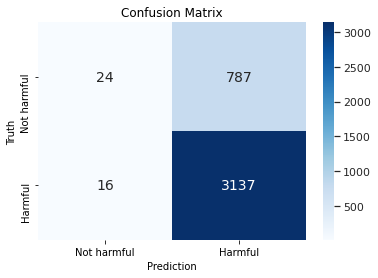

In [18]:
#Evaluating the model : 
with torch.no_grad():
  input_ids = test_dataset[:]['input_ids'].to(device)
  attention_mask = test_dataset[:]['attention_mask'].to(device)
  labels = test_dataset[:]['labels'].to(device)
  outputs = model(input_ids, attention_mask=attention_mask)

  metrics_camembert=compute_metrics(labels.cpu().data.numpy(),outputs[0].cpu().data.numpy()[:,1], confusion=True)

Il faut utiliser cette cellule pour sauvegarder le modèle dans un fichier de son choix : 

In [ ]:
# model.save_pretrained("/content/drive/MyDrive/article_1_model/camembert_v1")

In [19]:
metrics_df=pd.DataFrame(metrics_camembert.reshape((1,-1)), columns=["f1", "best_precision", "best_recall", "roc_auc", "acc"], index=["CamemBERT"])


In [20]:
metrics_df.head()

,f1,best_precision,best_recall,roc_auc,acc
CamemBERT,0.886534,0.79949,0.995243,0.681144,0.797427


On remarque que les performances présentées ici sont très similaires à celle vues pour les algorithmes de BoW et TF-IDF.
Chaque modèle semble donc plafonner à un certain stade, ce qui semble indiquer que le set de test est trop différent du set d'entraînement.

## Analyse : Quelles implications sur les messages à modérer A1 ? 

In [21]:
test_values=np.array(test["tweet"])
test_labels=np.array(test["sentiment"])

train_values=np.array(df_to_moderate["content"])
train_values=[str(train_values[i]) for i in range(len(train_values))]
train_labels=np.array(df_to_moderate["Harmful"])

 ### Test avec Camembert:


In [22]:
a1_test = tokenizer(np.array(df_a1_to_moderate["content"]).tolist(), padding=True, truncation=True)
a1_test_dataset=A1Dataset(a1_test,np.zeros(df_a1_to_moderate.shape[0]))

In [23]:
model.load_state_dict(torch.load("/content/drive/MyDrive/article_1_data/camembert.pt"))
predictions=[]

test_loader=DataLoader(a1_test_dataset, batch_size=16, shuffle=False)
with torch.no_grad():
  for batch in test_loader:

    inputs_test=batch["input_ids"].to(device)
    attention_mask_test=batch["attention_mask"].to(device)
    outputs=model(inputs_test,attention_mask=attention_mask_test)
    predictions.append(np.argmax(outputs[0].cpu().data.numpy(), axis=1).tolist())


In [ ]:
predictions=[item for sublist in predictions for item in sublist]

print(f"Le modèle fait ressortir {sum(predictions)} messages problématiques")
print(f"Sur {len(predictions)} messages")
print(f"Le modèle détecte {sum(predictions)/len(predictions)} messages à modérer")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
indexes_camembert=[ i for i in range(len(predictions)) if predictions[i]==1]
df_a1_bow_moderate=df_a1_to_moderate.iloc[indexes_camembert]

for i in range(51): 
  print(df_a1_bow_moderate.iloc[i]["content"])

[36, 77, 210, 316, 521, 534, 1124, 1273, 1538, 1849, 2008, 2169, 2267, 2286, 2287, 2291, 2313, 2347, 2498, 2499, 2763, 2911, 3194, 3497, 4001, 4199, 4200, 4201, 4204, 4206, 4208, 4211, 4213, 4214, 4217, 4220, 4227, 4701, 4783, 5459, 5628, 6095, 6112, 6149, 6504, 6507, 6512, 7092, 7199, 7805, 7853]
t'es un amour merciiiiiiiiii
*inébranlable est un caprice de mon correcteur automatique
Hello Léane* !! correcteur farceur :)
woaw t’es grave deter mdrr
https://drive.google.com/file/d/1lkHW998wL4xGX-ptekBuJ09iroz_PMdz/view?usp=drivesdk
Merci, tes réponses sont très complètes ! TooGoodToGo va devenir mon meilleur ami ahah
La communication aha
Après paris j’y penses paaas vrmnt pck j’veux pas partir non plus loin de chez moi, je suis vers cannes 06
Quel hasard que tu soit à pissarro !
D’accord merveaucoup pour l’aide
Insta : nonoo__o 
:)
Derien, il y a pas de quoi
Mais oui sinon c’est abusé je suis d’accord mdrr
Ok vas-y
et oui vas-y passes sur insta
Ah ouais ! En fait c’est compliqué ct’histo

Beaucoup moins de messages ressortent, et surtout les messages semblent plus cohérent (présence de snapchat, insta, facebook ou encore smiley). On note cependant que cela reste des messages relativement "innocents".

On détecte de plus seulement X % de messages à modérer, pour rappel l'algortihme actuel en fait ressortir 20%.

## Test approche Stopwords


In [ ]:
stopwords_df=pd.read_csv("/content/drive/MyDrive/article_1_data/stopwords.csv",header=None,names=["word"])
stopwords_df.head()

,word
0,arabes
1,baisable
2,biatch
3,bifle
4,bite


In [ ]:
df_a1_to_moderate_stopwords=df_a1_to_moderate
df_a1_to_moderate_stopwords["stopwords"]=False
df_a1_to_moderate_stopwords["stopwordsCount"]=0
df_a1_to_moderate_stopwords.head()

,content,stopwords,stopwordsCount
0,"Non, la physique-chimie de lycée n’a pas grand...",False,0
1,Merci infiniment d'avoir pris autant de temps ...,False,0
2,Bonjour ! Alors non la SVT et la biologie ce n...,False,0
3,salut\nJ'aimerais savoir ce qu'est exactement ...,False,0
4,je sais pas si j'ai répondu à toutes tes quest...,False,0


In [ ]:
  df_a1_to_moderate["content"]

for a1_index, a1_row in df_a1_to_moderate_stopwords.iterrows():
  for s_index, s_row in stopwords_df.iterrows():
    if (s_row["word"] in a1_row["content"]):
      df_a1_to_moderate_stopwords.at[a1_index,"stopwords"]=True

      df_a1_to_moderate_stopwords.at[a1_index,"stopwordsCount"]=df_a1_to_moderate_stopwords.at[a1_index,"stopwordsCount"]+1

In [ ]:
df_a1_to_moderate_stopwords.head()

,content,stopwords,stopwordsCount
0,"Non, la physique-chimie de lycée n’a pas grand...",False,0
1,Merci infiniment d'avoir pris autant de temps ...,True,1
2,Bonjour ! Alors non la SVT et la biologie ce n...,True,1
3,salut\nJ'aimerais savoir ce qu'est exactement ...,False,0
4,je sais pas si j'ai répondu à toutes tes quest...,False,0


In [ ]:
df_a1_to_moderate_stopwords.stopwords.value_counts()

False    6529
True     1704
Name: stopwords, dtype: int64